 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook we study tabular actor-critic algorithms using $V$ or $Q$ and different critic update rules.

In particular, we are interested in the behavior of these algorithms under a uniform (state, action) pair sampling regime and the standard on-policy regime.

We compare the capability of these algorithms to approximate the optimal critic
and their performance in terms of number of steps to exit a maze.

we also investigate the case where the action is drawn from the actor, or from the critic, in the case where we are using a $Q$ critic.

The underlying question is whether all these algorithms are off-policy or on-policy and why.

## Install libraries

In [1]:
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run
    assert run(["pip", "install", "easypip"]).returncode == 0, "Could not install easypip"
    from easypip import easyimport

# easyimport("swig")
# easyimport("bbrl_utils").setup(maze_mdp=True)

import os
import random
from pathlib import Path
from typing import List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
import tqdm
from mazemdp.mdp import Mdp
from mazemdp.toolbox import egreedy, egreedy_loc, sample_categorical, softmax
from mazemdp import random_policy
import bbrl_gymnasium  # noqa: F401

from functools import partial
import yaml
import hydra
from omegaconf import OmegaConf, DictConfig

import seaborn as sns
sns.set_theme()

from enum import Enum

Matplotlib backend: module://matplotlib_inline.backend_inline


# Studied critic update rules

In what follows you will implement the following update rules for the V-values and Q-values:

#### Type 0: Standard V-based TD Update Rule:

We first compute the TD error: $delta = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)$

Then we apply it to the critic: $V(s_t) ← V(s_t) + \alpha_{critic} delta$

That is: $V(s_t) ← V(s_t) + \alpha_{critic} [r_{t+1} + \gamma V(s_{t+1}) - V(s_t)]$

Which can also be written: $V(s_t) ← (1- \alpha_{critic}) V(s_t) + \alpha_{critic}[r_{t+1} + \gamma V(s_{t+1})]$

This rule is the standard temporal difference update rule

#### Type 1: Q-learning Update Rule:

$Q(s_t, a_t) ← Q(s_t, a_t) + \alpha_{critic} [r_{t+1} + \gamma max_a Q(s_{t+1}, a) - Q(s_t, a_t)]$

Which can also be written: $Q(s_t, a_t) ← (1- \alpha_{critic}) Q(s_t, a_t) + \alpha_{critic}[r_{t+1} + \gamma max_a Q(s_{t+1}, a)]$

This rule is the standard Q-learning update rule, it follows the off-policy approach.

#### Type 2: SARSA Update Rule:

$Q(s_t, a_t) ← Q(s_t, a_t) + \alpha_{critic} [r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]$

Which can also be written: $Q(s_t, a_t) ← (1- \alpha_{critic}) Q(s_t, a_t) + \alpha_{critic}[r_{t+1} + \gamma Q(s_{t+1}, a_{t+1})]$

where $a_{t+1}$ is given by the current policy

This rule follows the on-policy approach, where we take the Q value of the next action according to the policy.

#### Type 3: "Expectation" Q-learning Update Rule:

$Q(s_t, a_t) ← Q(s_t, a_t) + \alpha_{critic} [r_{t+1} + \gamma \sum_a \pi(a|s_{t+1}) max_a Q(s_{t+1}, a) -  Q(s_t, a)]$

Which can also be written: $Q(s_t, a_t) ← (1- \alpha_{critic}) Q(s_t, a_t) + \alpha_{critic}[r_{t+1} + \gamma \sum_a \pi(a|s_{t+1}) max_a Q(s_{t+1}, a) -  Q(s_t, a)]$

This rule leverages the expected value of the Q-function over all actions given the current policy.

If follows from the relation between the value function and the action value function $V^pi(s_t) = \sum_a \pi(a|s_t) Q(s_t, a)]$.

#### Type 4: "Max" Q-learning Update Rule:

$Q(s_t, a_t) ← Q(s_t, a_t) + \alpha_{critic} [r_{t+1} + \gamma max_a Q(s_{t+1}, a) - max_a Q(s_t, a)]$

This rule makes little sense when one considers the $Q(s_t, a_t) ← (1- \alpha_{critic}) Q(s_t, a_t) + \alpha_{critic}[something else]$ notation,
But we keep it because its behavior is interesting.

### Implementation of the critic update rules

You have to implement the above critic update rules yourself.

We suggest using a single `update_critic()` function that works both for $V$ and $Q$
though $V$ uses only the state as parameter whereas $Q$ uses a (state, action) pair.

The price to pay for this unification is that we call `q` the corresponding array, no matter whether it represents $V$ or $Q$.
Students can change the code if they want to move away from this approach.

We need to return the temporal difference error delta because it can be used to also update the actor

In [21]:
# Useful to plot curves and to enumerate the different cases with explicit labels

type_names = ["TD", "Qlearning", "SARSA", "ExpectationQlearning", "MaxQlearning"]
action_choice_names = ["Critic-based", "Policy-based"]
nb_types = 5

class UpdateType(Enum):
    TD = 0
    Qlearning = 1
    SARSA = 2
    ExpectationQlearning = 3
    MaxQlearning = 4

class ActionChoice(Enum):
    Critic = 0
    Policy = 1

In [2]:
def update_critic(
    update_type: int,
    policy: np.array,
    q: np.array,
    alpha_critic: float,
    state: int,
    action: int,
    next_state: int,
    next_action: int,
    terminated: bool,
    reward: float,
) -> float:
    """
    Update a critic with different update types and return the temporal difference error
    :param update_type: from 0 to 4, corresponds to the above update rules
    :param policy: the current policy that is trained
    :param q: the critic, can represent either a $V$ or a $Q$ function
    :param alpha_critic: the critic learning rate
    :param state: the current state where the update is performed
    :param action: the current action (can come from the current policy or from uniform sampling)
    :param next_state: the next state
    :param next_action: the next action (can come from the current policy or from uniform sampling)
    :param terminated: whether the trajectory terminates (if True, the Bellman backup should be ignored)
    :param reward: the received reward
    :return delta: the computed temporal difference error
    """

    # [[students]]
    # max Q-value for the next state
    max_q_next = np.max(q[next_state])
        
    # TD error (delta) based on the selected update type
    if update_type == UpdateType.TD.value:
        # 1: TD update rule. Here the variable q is in fact a V function
        delta = reward + env.gamma * q[next_state] * (1 - terminated) - q[state]

    elif update_type == UpdateType.Qlearning.value:
        # 2: Q-learning update rule
        delta = reward + env.gamma * max_q_next * (1 - terminated) - q[state, action]

    elif update_type == UpdateType.SARSA.value:
        # 1: SARSA update rule
        delta = reward + env.gamma * q[next_state, next_action] * (1 - terminated) - q[state, action]

    elif update_type == UpdateType.MaxQlearning.value:
        # 3: Max Q-learning update rule
        delta = reward + env.gamma * max_q_next * (1 - terminated) - np.max(q[state])

    elif update_type == UpdateType.ExpectationQlearning.value:
        # 4: Expectation Q-learning update rule
        q_next = 0
        for ac in range(env.action_space.n):
            q_next += policy[next_state, ac] * q[next_state, ac]
        delta = reward + env.gamma * q_next * (1 - terminated) - q[state, action]
        
    else:
        raise ValueError(f"Invalid update type: {update_type}")

    # [[\students]]

    # Update the critic
    if update_type == 0:
        q[state] += alpha_critic * delta
    else:
        q[state, action] += alpha_critic * delta
    return delta

## Actor update

To update the actor, naively applying the same learning rule
would not ensure that the probabilities of all actions in a state sum to 1.
Besides, when the temporal difference error $\delta_t$ is negative,
it may happen that the probability of an action gets negative or null,
which raises an issue when applying renormalization.

So, instead of applying the naive rule, we apply the following one:
$$ 
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

Then we can apply renormalization so that the probabilities of actions still sum to 1, with
$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$ with
$$ 
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

You have to provide the corresponding code below.

### Implementation

In [3]:
def renormalize(
    policy: np.array,
    state: int,
) -> None:
    """
    Renormalize the probability of actions so that the sum of probabilities over actions is always 1.
    We made sure in the calling function that the probabilities of action never get negative when they are decreased.
    :param policy: the current policy, before normalization
    :param state: the state where the actions need to be renormalized
    :return: nothing
    """
    # [[students]]
    policy[state] = policy[state] / np.sum(policy[state])
    # [[\students]]

def update_policy(
    policy: np.array,
    delta: np.array,
    state: int,
    action: int,
    alpha_actor: float, 
) -> None:
    """
    Update the policy from the temporal difference error, using renormalization
    :param policy: the current policy
    :param delta: the temporal difference error
    :param state: the current state
    :param delta: the current action
    :param alpha_actor: the actor learning rate
    :return: nothing
    """
    
    # [[students]]
    policy_temp = policy[state, action] + alpha_actor * delta
    policy[state, action] = max(policy_temp, 1e-8)

    renormalize(policy, state)
    # [[\students]
    # Used to make sure normalization works properly
    assert np.isclose(np.sum(policy[state]), 1.0), "Policy is not properly normalized!"

# Utilities

Once you have coded the core algorithms above, most of the code below is provided
to let you obtain curves and analyze them on your own
(apart from value iteration functions that you have coded during labs).

Feel free to change anything in this code if you want to provide other analyses.

## Actor-critic hyper-parameters

To represent the hyper-parameters of the experiments performed in this notebook, we suggest using the dictionary below.
This dictionary can be read using omegaconf.
Using it is not mandatory.
You can also change the value of hyper-parameters or environment parameters at will.

In [4]:
ac_params = {
    "maze": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "human",
        },

    "nb_episodes": 150,
    "nb_samples": 1500,
    "nb_repeats": 5,

    "alpha_critic": 0.98,
    "alpha_actor": 0.95,
    "gamma": 0.95,
    }

## Create the mdp

In [5]:
def make_mdp(cfg):
    """
    Return the MazeMDP and an unwrapped version, used to access the attributes and function without raising a warning.
    We also need the not unwrapped env for calling steps otherwise truncation beyond time limit will not apply
    """
    # Environment with 20% of walls and no negative reward when hitting a wall
    mdp = gym.make(
        "MazeMDP-v0",
        kwargs={"width": cfg.maze.width, "height": cfg.maze.height, "ratio": cfg.maze.ratio, "hit": 0.0, "start_states": [0]},
        render_mode=cfg.maze.render_mode,
    )
    env = mdp.unwrapped  # the .unwrapped removes a warning from gymnasium when accessing an attribute or function
    return mdp, env

cfg=OmegaConf.create(ac_params)
mdp, env = make_mdp(cfg)
mdp.reset()
env.init_draw("The maze")
env.gamma = cfg.gamma

       [ 1,  5,  8, 12, 16],
       [ 2, -1,  9, …

## Get optimal critic

To evaluate the above algorithms, you will compare the obtained $V$ and $Q$ critics to their optimal counterpart.

To obtain the optimal $V$ and $Q$ critics, we suggest using the value iteration algorithm with the $V$ function and the $Q$ function
that you have coded during labs (and `get_policy_from_v()` if need be).

In [6]:
# [[students]]

def get_policy_from_v(v: np.ndarray) -> np.ndarray:
    """Outputs a policy given the state values"""

    # Sets initial state values are set to 0
    policy = np.zeros(env.nb_states)  

    # Loop over MDP states
    for x in range(env.nb_states):
        if x in env.terminal_states:
            # Takes the reward associated with the terminal state
            policy[x] = np.argmax(env.r[x, :])
        else:
            # Compute the value V(x) for state x
            v_temp = []
            
            # Loop over actions
            for u in range(env.action_space.n):
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(env.nb_states):
                    summ = summ + env.P[x, u, y] * v[y]
                v_temp.append(env.r[x, u] + env.gamma * summ)
            policy[x] = np.argmax(v_temp)
    return policy

def value_iteration_v(
    render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    # Value Iteration using the state value v
    v = np.zeros(env.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False

    while not stop:
        v_old = v.copy()

        for x in range(env.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            if x in env.terminal_states:
                v[x] = np.max(env.r[x, :])
            else:
                v_temp = []
                for u in range(env.action_space.n):
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(env.nb_states):
                        summ = summ + env.P[x, u, y] * v_old[y]
                    v_temp.append(env.r[x, u] + env.gamma * summ)

                # Select the highest state value among those computed
                v[x] = np.max(v_temp)

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    policy = get_policy_from_v(v)
    return v, v_list

In [7]:
# ------------------ Value Iteration with the Q function ---------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function

def value_iteration_q(
        render: bool = True
) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros(
        (env.nb_states, env.action_space.n)
    )  # initial action values are set to 0
    q_list = []
    stop = False

    while not stop:
        qold = q.copy()

        for x in range(env.nb_states):
            for u in range(env.action_space.n):
                if x in env.terminal_states:
                    q[x, u] = env.r[x, u]
                else:
                    summ = 0
                    for y in range(env.nb_states):
                        summ += env.P[x, u, y] * np.max(qold[y, :])

                    # Compléter d'après la formule ci-dessus

                    q[x, u] = env.r[x, u] + env.gamma * summ

        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    return q, q_list

# [[/students]]

## IQM and percentiles

These utilities are useful to provide meaningful measures of variability
when plotting learning curves.

### Calculate IQM and percentiles

Calculate the interquartile mean using the percentiles between min_bound and max_bound

In [8]:
def calculate_iqm(all_steps, min_bound, max_bound):
      """
      Calculate the Interquartile Mean (IQM) for the given data.
      :param all_steps: Array of steps from multiple runs
      :return: IQM array
      """
      # Calculate the min and max percentiles
      steps_min = np.percentile(all_steps, min_bound, axis=0)
      steps_max = np.percentile(all_steps, max_bound, axis=0)

      # IQM calculation: mean of values between min and max percentiles
      steps_iqm = np.mean(np.clip(all_steps, steps_min, steps_max), axis=0)

      return steps_iqm, steps_min, steps_max

###  Plot function: IQM and percentiles

Plot the Interquartile mean and corresponding percentiles with a label

In [9]:
def plot_quartiles(q_iqm, q_low, q_high, label):
    plt.plot(range(len(q_iqm)), q_iqm, label=label)
    plt.fill_between(range(len(q_iqm)),
                     q_low,
                     q_high,
                     alpha=0.2)

###  Plot function: errors, steps or norms

The plot results function below receives some data to be plotted that can correspond
to critic errors, number of steps to exit the maze or norms of critic arrays.

In [11]:
def plot_results(results, results_string):

    if not os.path.exists('plots'):
        os.makedirs('plots')

    plt.figure(figsize=(12, 8))
    plt.title(f"{results_string} - Comparison of Update Rules (gamma={env.gamma})")
    plt.xlabel("Number of episodes")
    plt.ylabel(f"{results_string}")
    plt.grid(True, linestyle="--", alpha=0.6)

    for type in range(nb_types):
        res = np.array(results[type])
        results_iqm, results_min, results_max = calculate_iqm(res, 25, 75)
        plot_quartiles(results_iqm, results_min, results_max, f"type {type}: {type_names[type]}")

    plt.legend(loc="upper right")

    plot_filename = f"{results_string}_alpha_critic_{cfg.alpha_critic}.pdf"
    plot_filepath = os.path.join('plots', plot_filename)

    # Save into "plots" folder
    plt.savefig(plot_filepath)
    print(f"Plot saved to {plot_filepath}")

    plt.show()    

### Uniform sampling of state, action, next action triples

In [12]:
def draw_full_uniform() -> Tuple[int, int, int]:
     state = random.randint(0, env.nb_states-1)
     action = env.action_space.sample()
     next_action = env.action_space.sample()
     return state, action, next_action

### Uniform sampling of state, action, and using the policy for the next action

In [13]:
def draw_uniform(policy) -> Tuple[int, int, int]:
     state = random.randint(0, env.nb_states-1)
     action = env.action_space.sample()
     next_action = sample_categorical(policy[state])  # draw action from the policy
     return state, action, next_action

### Choosing the action, either from the critic (when using a $Q$ fuynction) or the policy

If we are using a stochastic policy, we sample from that policy.
If we are using a critic, we add epsilon greedy noise to determine the action.

In [14]:
def get_action(action_choice, update_type, policy, critic, state, epsilon):
    if action_choice == ActionChoice.Policy.value:
        action = sample_categorical(policy[state])
    elif action_choice == ActionChoice.Critic.value:
        assert (update_type != UpdateType.TD.value), "cannot choose action from a V critic"
        action = egreedy(critic, state, epsilon)
    else:
        raise ValueError(f"Invalid update type: {update_type}")
    return action

### Performing episodes, with or without training the critic and policy

Perform an episode where the action is chosen either by the stochastic policy or by the critic

In [15]:
def perform_episode(
    training: bool,
    update_type: int,
    action_choice: int,
    policy: np.array,
    critic: np.array,
    critic_ref: np.array,
    alpha_critic: float,
    alpha_actor: float,
    epsilon=0.4,
) -> Tuple[float, int]:
    """
    Perform an episode
    :param training: whether the policy is trained or not while performing the episode (useful to separate training and evaluation)
    :param update_type: int indicating the chosen update rule.
    :return: the number of steps before it stops and the norm of the error with respect to the optimal critic.
    """
    state, _ = mdp.reset()  # reinit env, get initial state
    terminated = False
    truncated = False
    steps = 0

    action = get_action(action_choice, update_type, policy, critic, state, epsilon)

    while not (terminated or truncated):

        next_state, reward, terminated, truncated, _ = mdp.step(action)

        next_action = get_action(action_choice, update_type, policy, critic, next_state, epsilon)

        if training:
            delta = update_critic(update_type, policy, critic, alpha_critic, state, action, next_state, next_action, terminated, reward)
            update_policy(policy, delta, state, action, cfg.alpha_actor)

        # Move to the next state
        state = next_state
        steps += 1
        action = next_action

        # Track the difference between the critic and the optimal critic

        critic_norm = np.linalg.norm(critic-critic_ref)

    return steps, critic_norm

## Study of the uniform sampling case

In [16]:
def actor_critic_uniform(
    update_type: int,
    action_choice: int,
    nb_samples: int,
    critic: np.array,
    critic_ref: np.array,
    alpha_critic: float,
    alpha_actor: float,
) -> np.array:
    """
    Train a critic using samples drawn uniformly.
    The obtained critic is compared through time to a reference critic
    :param update_type: int indicating the chosen update rule
    :return: a list of norm of difference between Q values and reference Q values, and a list of number of steps to exit the maze
    """

    # Initialize uniform policy
    policy = np.ones((env.nb_states, env.action_space.n)) / env.action_space.n
    
    nb_steps = []
    q_errors = []

    for step in range(nb_samples):
        state, action, next_action = draw_uniform(policy)
        env.mdp.current_state = state
        next_state, reward, terminated, _, _ = mdp.step(action)
        delta = update_critic(update_type, policy, critic, alpha_critic, state, action, next_state, next_action, terminated, reward)
        error = np.linalg.norm(critic - critic_ref)
            
        update_policy(policy, delta, state, action, cfg.alpha_actor)
        q_errors.append(error)

        if step % 10 == 0:
            steps, _ = perform_episode(False, update_type, action_choice, policy, critic, critic_ref, alpha_critic, alpha_actor=0.0)
            nb_steps.append(steps)

    return q_errors, nb_steps

Running evaluation based on uniform sampling

In [ ]:
def run_uniform():
    v_ref, _ = value_iteration_v()
    q_ref, _ = value_iteration_q()
    errors = np.zeros((nb_types, cfg.nb_repeats, cfg.nb_samples))
    steps = np.zeros((nb_types, cfg.nb_repeats, int(cfg.nb_samples/10)))
    for action_choice in range(2):
        print(f"action choice : {action_choice_names[action_choice]}")
        for update_type in range(nb_types):
            errors_list = []
            steps_list = []
            for _ in range(cfg.nb_repeats):
                # Initialize Q-values and V-values to zero
                v = np.zeros(env.nb_states)
                q = np.zeros((env.nb_states, env.action_space.n))
                if update_type == UpdateType.TD.value:
                    error, step = actor_critic_uniform(update_type, ActionChoice.Policy.value, cfg.nb_samples, v, v_ref, cfg.alpha_critic, cfg.alpha_actor)
                else:
                    error, step = actor_critic_uniform(update_type, action_choice, cfg.nb_samples, q, q_ref, cfg.alpha_critic, cfg.alpha_actor)
                errors_list.append(error)
                steps_list.append(step)
            errors[update_type] = errors_list
            steps[update_type] = steps_list
        plot_results(errors, f"critic_error_uniform_{action_choice_names[action_choice]}")
        plot_results(steps, f"steps2exit_uniform_{action_choice_names[action_choice]}")

## Standard online, on-policy learning case

In [18]:
def actor_critic_online(
    update_type: int,
    action_choice: int,
    nb_episodes: int,
    v_ref: np.array,
    q_ref: np.array,
    alpha_critic: float,
    alpha_actor: float,
) -> Tuple[np.array, int, np.array, np.array]:
    """
    Perform actor-critic training over a number of episodes with Q-values.
    :param update_type: int indicating the chosen update rule
    :return: a list of number of steps of episodes and a list of norm of critic values
    """
    # Initialize Q-values and V-values to zero
    q = np.zeros((env.nb_states, env.action_space.n))
    v = np.zeros(env.nb_states)

    # Initialize uniform policy
    policy = np.ones((env.nb_states, env.action_space.n)) / env.action_space.n

    # Store the number of steps and norms
    nb_steps = []
    critic_errors = []

    for ep in range(nb_episodes):
        if update_type == 0:
            steps, critic_error = perform_episode(True, update_type, ActionChoice.Policy.value, policy, v, v_ref, alpha_critic, alpha_actor)
        else:
            steps, critic_error = perform_episode(True, update_type, action_choice, policy, q, q_ref, alpha_critic, alpha_actor)
        critic_errors.append(critic_error)
        nb_steps.append(steps)

    return nb_steps, critic_errors

Running evaluation based on online RL

In [19]:
def run_online():
    v_ref, _ = value_iteration_v()
    q_ref, _ = value_iteration_q()
    steps = np.zeros((nb_types, cfg.nb_repeats, cfg.nb_episodes))
    vals = np.zeros((nb_types, cfg.nb_repeats, cfg.nb_episodes))

    for action_choice in range(2):
        print(f"action choice : {action_choice_names[action_choice]}")
        for update_type in range(nb_types):
            vals_list = []
            steps_list = []
            for _ in range(cfg.nb_repeats):
                nb_steps, critic_errors = actor_critic_online(update_type, action_choice, cfg.nb_episodes, v_ref, q_ref, cfg.alpha_critic, cfg.alpha_actor)
                vals_list.append(critic_errors)
                steps_list.append(nb_steps)
            steps[update_type] = steps_list
            vals[update_type] = vals_list
        plot_results(vals, f"critic_error_on-policy_{action_choice_names[action_choice]}")
        plot_results(steps, f"steps2exit_on-policy_{action_choice_names[action_choice]}")

Run the whole thing

action choice : Critic-based
Plot saved to plots\critic_error_uniform_Critic-based_alpha_critic_0.98.pdf


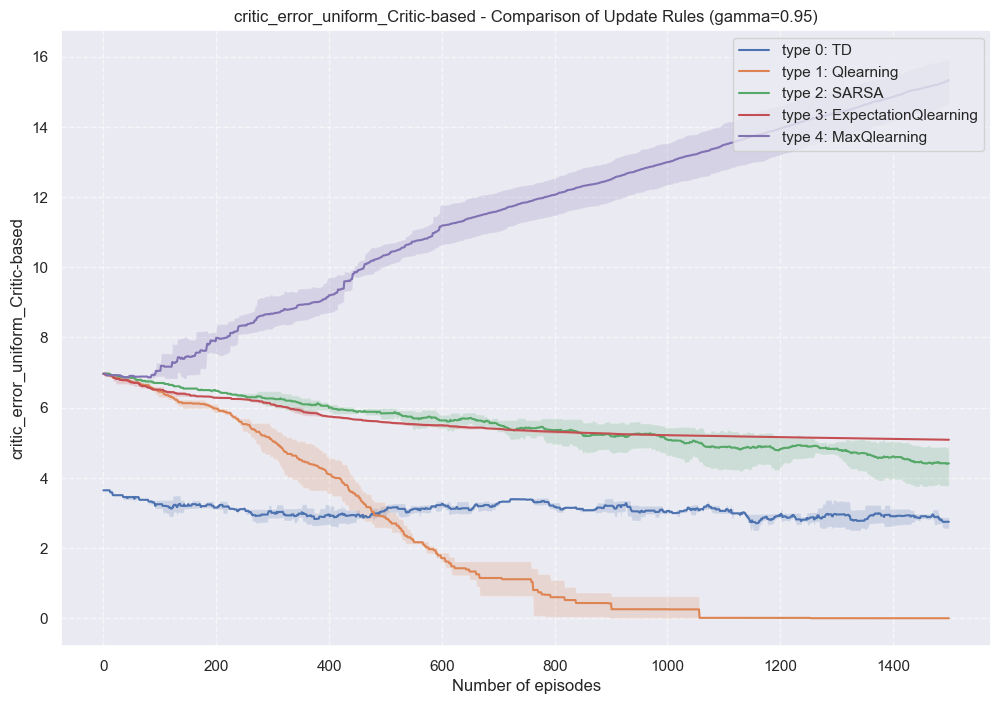

Plot saved to plots\steps2exit_uniform_Critic-based_alpha_critic_0.98.pdf


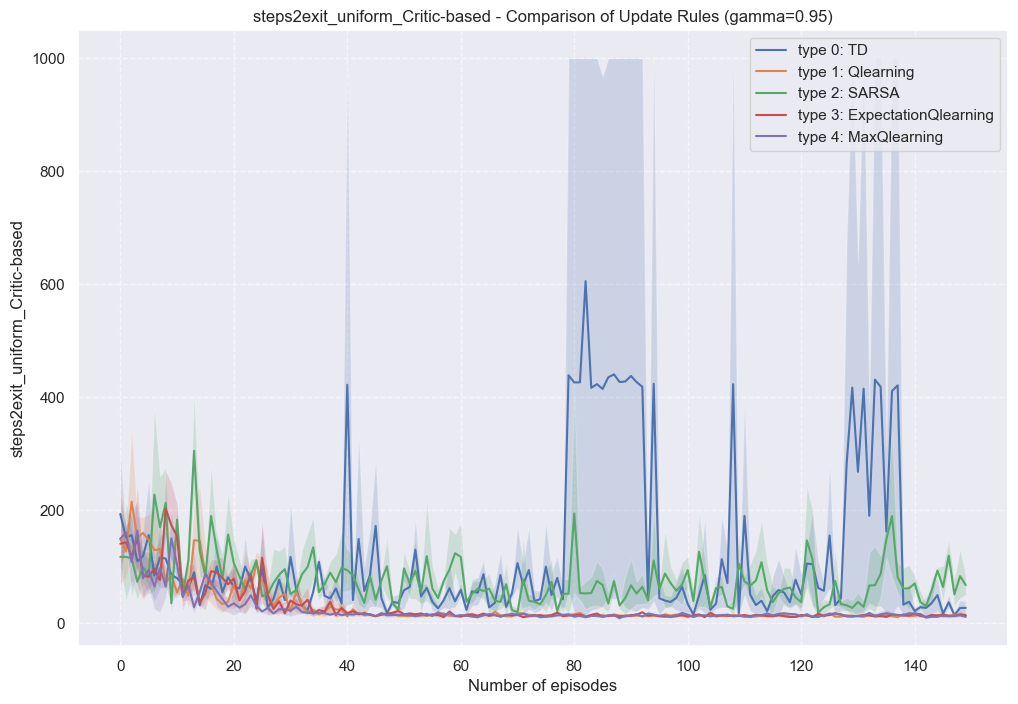

action choice : Policy-based
Plot saved to plots\critic_error_uniform_Policy-based_alpha_critic_0.98.pdf


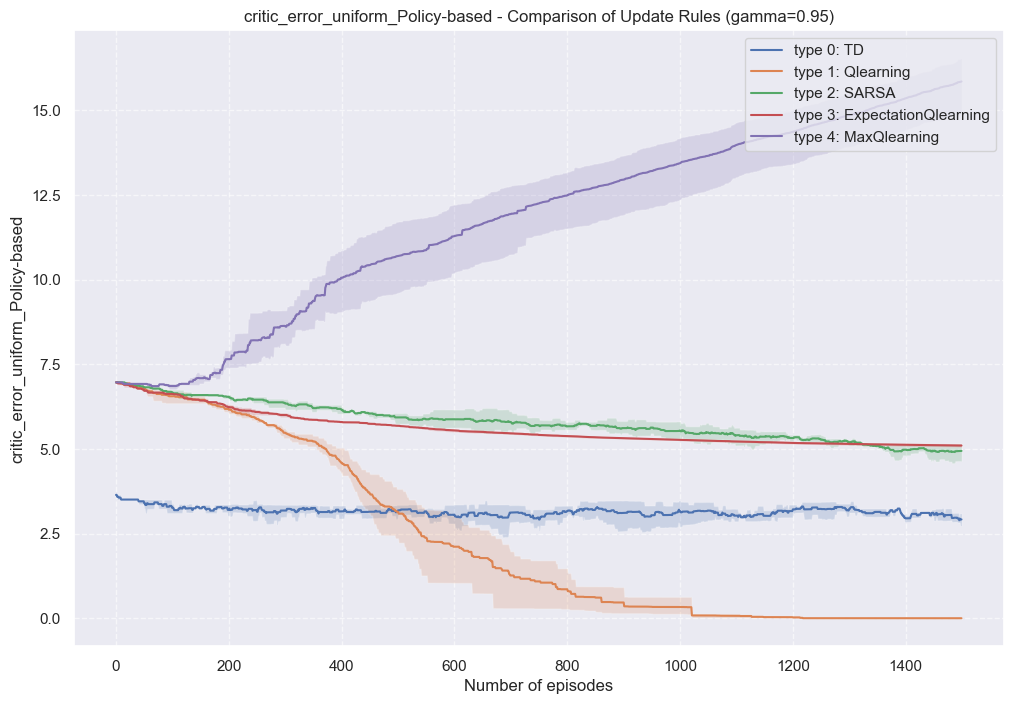

Plot saved to plots\steps2exit_uniform_Policy-based_alpha_critic_0.98.pdf


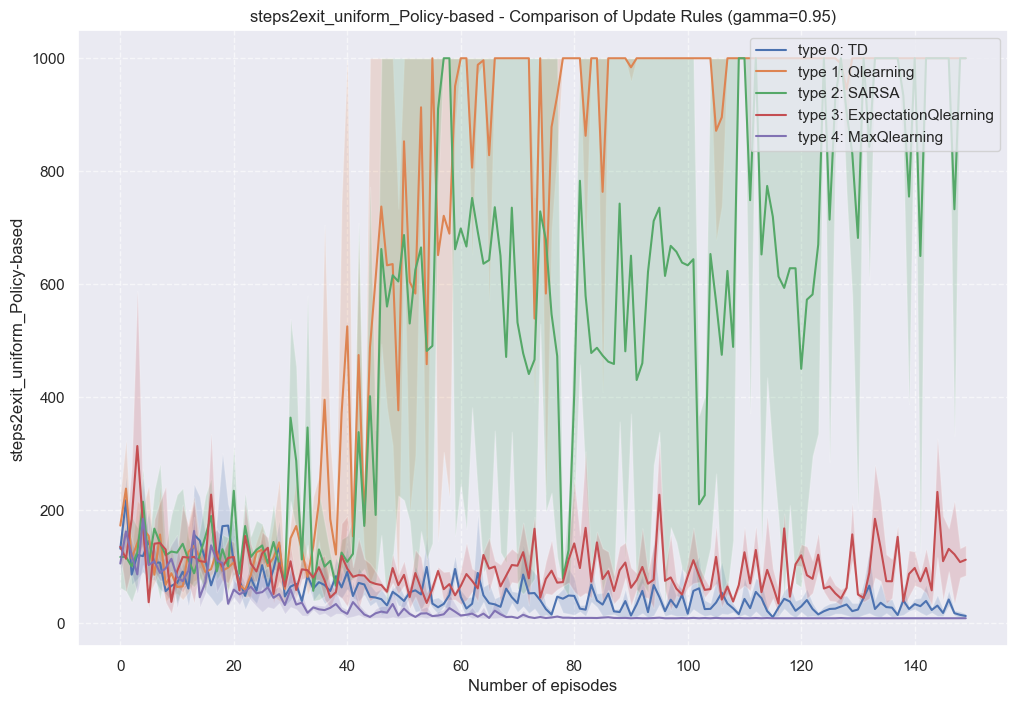

action choice : Critic-based
Plot saved to plots\critic_error_on-policy_Critic-based_alpha_critic_0.98.pdf


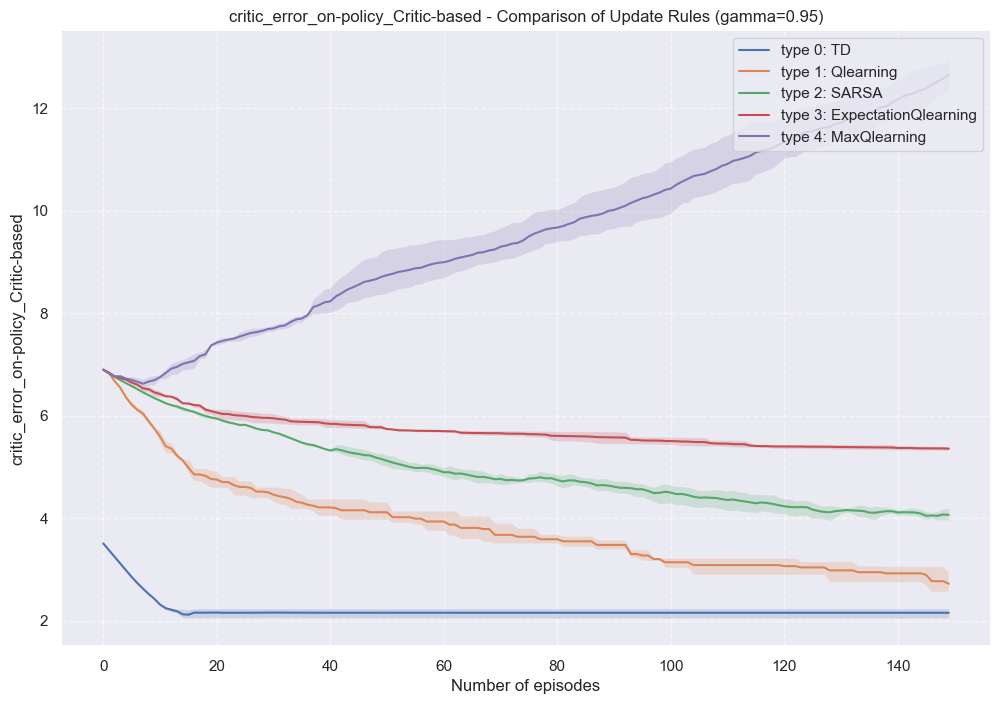

Plot saved to plots\steps2exit_on-policy_Critic-based_alpha_critic_0.98.pdf


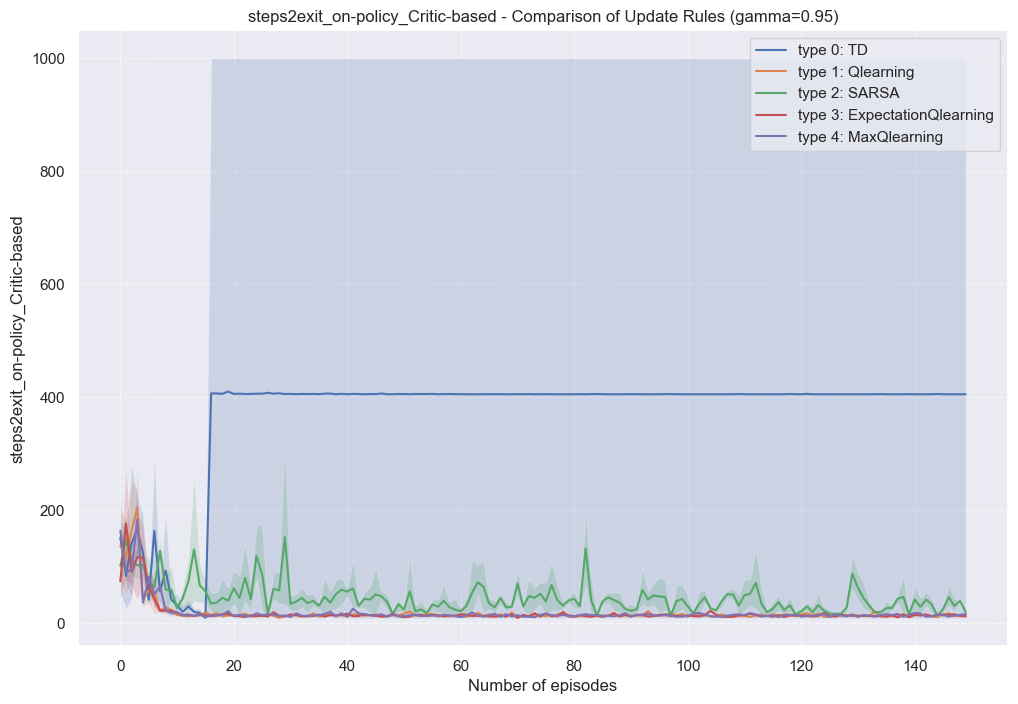

action choice : Policy-based
Plot saved to plots\critic_error_on-policy_Policy-based_alpha_critic_0.98.pdf


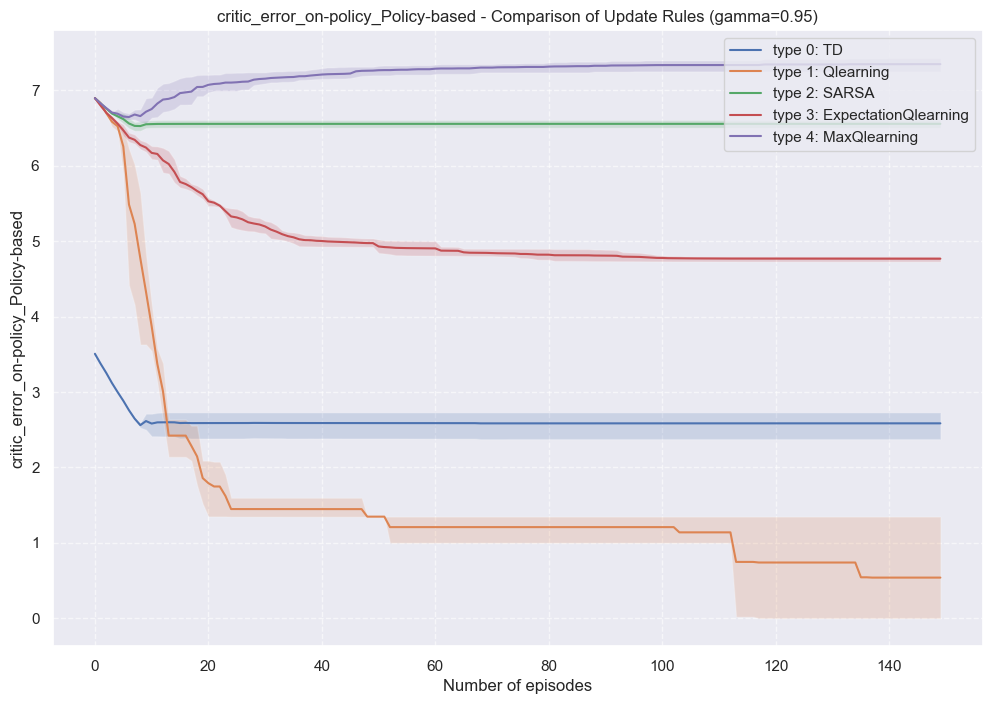

Plot saved to plots\steps2exit_on-policy_Policy-based_alpha_critic_0.98.pdf


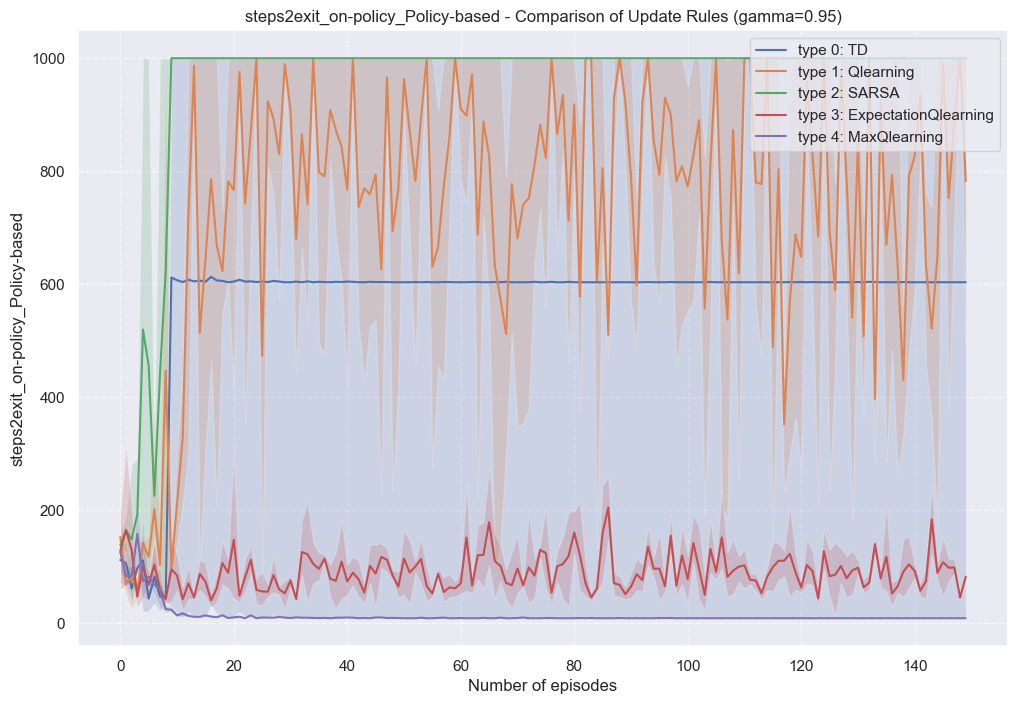

In [22]:
run_uniform()
run_online()

Write a report

Now your job is to write a pdf report which may contain the curves you have generated,
which explains what you see and which draws conclusions from these evaluations.
Fill free to remove curves that you don't want to comment or to provide additional
curves or figures.

Beware that if you want to assert that an algorithm outperforms another, you should validate your claim with a statistical test.

The report should be a pdf named name1_name2.pdf where name1 and name2 are the names of the authors.
It should not be longer than 6 pages and written in english.
Using LLMs to improve formulation is welcome, using it to generate thoughts about the work is strongly discouraged.
Do not forget you are here to learn how to think by yourselves.